In [8]:
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as cx

In [9]:
from utils import get_omgevingsvergunning_areas

DATA_FOLDER = Path("data/prorail")

# 1. Sherlock MTPS

In [10]:
df_sherlock = pd.read_parquet(DATA_FOLDER / "mtps_raw_parquet_2023-09_sherlock-export-datalab-mtps_2023-09-19.parquet")

In [11]:
df_sherlock.head()

,Treinnr,Matnr,Tijdstip,Latitude,Longitude,Snelheid_bron,Snelheid_correctie,Rijrichting,Spoortak,Spoortak_richting,Spoortaak_kmlint,Spoortak_kmwaarde,NCBG_drp,NCBG_spoor,NCBG_nauwkeurigheid,Ind_bron,Ind_treinnrstatus,Ind_snelheidstatus,uur
0,140,1750,2023-09-19 21:48:19,52.30649,6.980700,NaN,126.0,258,ODZ$263B$V,?,Hgl-Odzg,29409,None,None,NaN,1,4,2,2023-09-19 22:00:00
1,140,1750,2023-09-19 21:48:29,52.30585,6.975635,NaN,127.0,258,ODZ$263B$V,?,Hgl-Odzg,29049,None,None,NaN,1,4,3,2023-09-19 22:00:00
2,140,1750,2023-09-19 21:48:39,52.30548,6.970543,NaN,126.0,263,ODZ$263B$V,?,Hgl-Odzg,28706,None,None,NaN,1,4,3,2023-09-19 22:00:00
3,140,1750,2023-09-19 21:48:49,52.30547,6.965503,NaN,124.0,270,ODZ$263B$V,?,Hgl-Odzg,28360,None,None,NaN,1,4,3,2023-09-19 22:00:00
4,140,1750,2023-09-19 21:49:09,52.30620,6.956153,NaN,104.0,281,ODZ$263B$V,?,Hgl-Odzg,27710,None,None,NaN,1,4,2,2023-09-19 22:00:00


# 2. DIA MTPS

In [12]:
df_mtps = pd.read_parquet(DATA_FOLDER / 'mtps_2023_10_02_12.parquet')

In [13]:
# Duplicate data.
df_mtps = pd.concat([df_mtps]*5, ignore_index=True)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
df_points = gpd.GeoDataFrame(
    df_mtps[['longitude', 'latitude']], geometry=gpd.points_from_xy(df_mtps.longitude, df_mtps.latitude), crs="EPSG:4326"
)

print(len(df_points))
df_points.head()

338162


,longitude,latitude,geometry
0,5.492560,51.444623,POINT (5.49256 51.44462)
1,4.339515,52.073445,POINT (4.33952 52.07344)
2,6.175592,52.256939,POINT (6.17559 52.25694)
3,5.511456,52.548925,POINT (5.51146 52.54893)
5,5.884180,51.987080,POINT (5.88418 51.98708)


# 3. Spoortakken

In [ ]:
df_spoortak = gpd.read_parquet(DATA_FOLDER / "spoortakken.parquet").to_crs("EPSG:4326").drop_duplicates()

In [ ]:
def plot_spoortakken(df):
    fig, ax = plt.subplots(figsize=(10, 10))
    df.plot(ax=ax, color="black", linewidth=0.5, )
    cx.add_basemap(ax, crs=df_spoortak.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
    return fig, ax

In [ ]:
# _ = plot_spoortakken(df_spoortak)

# 3. Initial join

In [ ]:
# _, ax = plot_spoortakken(df_spoortak)
# df_points.plot(ax=ax, color="red", markersize=0.5)

In [ ]:
df_pointsp = df_points.to_crs('EPSG:28992')
df_spoortakp = df_spoortak.to_crs('EPSG:28992')

In [ ]:
from shapely.geometry import LineString
import numpy as np

In [ ]:
def segmentize(line, d=5):
    return LineString(
        [line.interpolate(l) for l in np.arange(0, line.length, d)]
        + [line.boundary.geoms[1]]
    )

def segments(curve):
    return list(map(LineString, zip(curve.coords[:-1], curve.coords[1:])))

In [ ]:
df_spoortakp['segments'] = df_spoortakp.geometry.apply(lambda x: segments(segmentize(x)))

In [ ]:
df_spoortakp.head()

,OBJECTID,PUIC,NAAM,POSITIONELE_NAUWKEURIGHEID_MM,LEVENSCYCLUS_STATUS,INTERLOCKING,ELEKTRISCHE_TRACTIE,SPANNINGKLASSE,NAAM_LANG,REF_BEGRENZER_TYPE_EIND,...,TREIN_TYPE,IN_GEBRUIK,LATITUDE_BEGIN,LATITUDE_EIND,LONGITUDE_BEGIN,LONGITUDE_EIND,KM_GEOCODE_TOT,KM_GEOCODE_VAN,geometry,segments
0,1039898,048ead42-5a98-4266-8f5d-9a79568ee548,57BL,None,Onbekend,Ja,Ja,1500 Volt,017_57BL_70.6,WISSEL_GW,...,Onbekend,Ja,52.413579,52.413028,5.902506,5.901530,70.518978,70.608079,"LINESTRING (190059.604 491875.906, 190056.688 ...",[LINESTRING (190059.6041490433 491875.90646295...
1,1039899,61819212-e4f8-493b-b5c3-805c87c3be3e,1345L,None,Onbekend,Ja,Ja,1500 Volt,116_1345L_31.8,WISSEL_GW,...,Onbekend,Ja,51.816976,51.817311,4.637113,4.636218,31.920355,31.848877,"LINESTRING (103280.354 425639.729, 103275.145 ...",[LINESTRING (103280.35406962213 425639.7294220...
2,1039900,2977b345-1fff-449e-8a2a-d79f80b01e95,1139L,None,Onbekend,Gedeeltelijk,Ja,25kV,478_1139L_0.7,WISSEL_GW,...,Onbekend,Ja,51.931820,51.930549,4.030751,4.032057,0.553077,0.713596,"LINESTRING (61711.961 439020.734, 61713.326 43...",[LINESTRING (61711.961031647385 439020.7344297...
3,1039901,19f296bc-2471-44f0-8d85-04d39765e336,445BR,None,Onbekend,Ja,Ja,1500 Volt,105_445BR_29.0,WISSEL_GW,...,Onbekend,Ja,52.014484,52.014343,4.751641,4.752847,28.883939,28.967637,"LINESTRING (111369.192 447537.942, 111372.957 ...",[LINESTRING (111369.19207737691 447537.9424360...
4,1039902,2403afc7-5d95-486d-90d1-3082bc1f69d7,351BR,None,Onbekend,Ja,Nee,Onbekend,521_351BR_22.2,WISSEL_GW,...,Onbekend,Ja,50.856131,50.856470,5.870519,5.868605,22.303081,22.163339,"LINESTRING (189034.013 318590.585, 188998.816 ...",[LINESTRING (189034.01314954407 318590.5853497...


In [ ]:
df_segments = df_spoortakp.explode('segments')
len(df_segments)

1570058

In [ ]:
df_segments['segment_id'] = df_segments.groupby('geometry').cumcount().astype(str).values

In [ ]:
df_segments.drop(columns=['geometry'], inplace=True)
df_segments.rename(columns={'segments': 'geometry', 'NAAM': 'branch_name'}, inplace=True)
df_segments = df_segments[['branch_name', 'geometry', 'segment_id']]
df_segments.set_geometry('geometry', drop=True, inplace=True, crs='EPSG:28992')

df_segments.head()

,branch_name,segment_id,geometry
0,57BL,0,"LINESTRING (190059.604 491875.906, 190055.766 ..."
0,57BL,1,"LINESTRING (190055.766 491872.702, 190051.948 ..."
0,57BL,2,"LINESTRING (190051.948 491869.474, 190048.204 ..."
0,57BL,3,"LINESTRING (190048.204 491866.161, 190044.592 ..."
0,57BL,4,"LINESTRING (190044.592 491862.704, 190041.030 ..."


In [ ]:
df_joined = df_pointsp.sjoin_nearest(df_segments, how="left", max_distance=4, distance_col="distance")

In [ ]:
df_joined

,longitude,latitude,geometry,index_right,branch_name,segment_id,distance
0,5.492560,51.444623,POINT (162324.672 383953.116),11904.0,119AP,74,0.001334
1,4.339515,52.073445,POINT (83172.795 454425.186),1246.0,961R,60,1.940515
2,6.175592,52.256939,POINT (208828.868 474615.483),3202.0,121R,120,0.000883
3,5.511456,52.548925,POINT (163427.866 506817.996),13961.0,917AQ,78,2.211876
5,5.884180,51.987080,POINT (189138.053 444415.163),19925.0,821L,41,1.132938
...,...,...,...,...,...,...,...
4749,4.869075,52.391599,POINT (119730.434 489431.558),13868.0,953L,27,0.003179
4752,5.512595,52.548844,POINT (163505.140 506809.131),169.0,917AS,94,0.001352
4755,5.349663,52.159110,POINT (152431.191 463438.790),360.0,379L,66,0.003336
4756,5.829341,52.523967,POINT (185006.720 504125.338),1622.0,2541V,1353,0.000737


# 3. NCBGs

In [ ]:
# Load NCBG polygons.
df_ncbg = get_omgevingsvergunning_areas(DATA_FOLDER / 'regions')
df_ncbg.head()

,OBJECTID,Shape,EMPLACEMEN,JDSNUMMER,STArea__,STLength__,geometry,regex
0,1,NaN,Leiden Centraal,3635629.0,83285.475543,509.0,"POLYGON ((4.47466 52.16128, 4.47466 52.16128, ...",True
1,2,NaN,Beverwijk,3732143.0,16001.898386,316.0,"POLYGON ((4.65393 52.47650, 4.65392 52.47650, ...",True
2,3,NaN,Utrecht Centraal Station,3735363.0,233241.949259,833.0,"POLYGON ((5.08696 52.09800, 5.08694 52.09800, ...",True
3,4,NaN,Arnhem West,3712004.0,184453.429502,474.0,"POLYGON ((5.87524 51.98714, 5.87524 51.98715, ...",True
4,5,NaN,Steenwijk,NaN,14013.100241,169.0,"POLYGON ((6.11151 52.79215, 6.11152 52.79216, ...",True


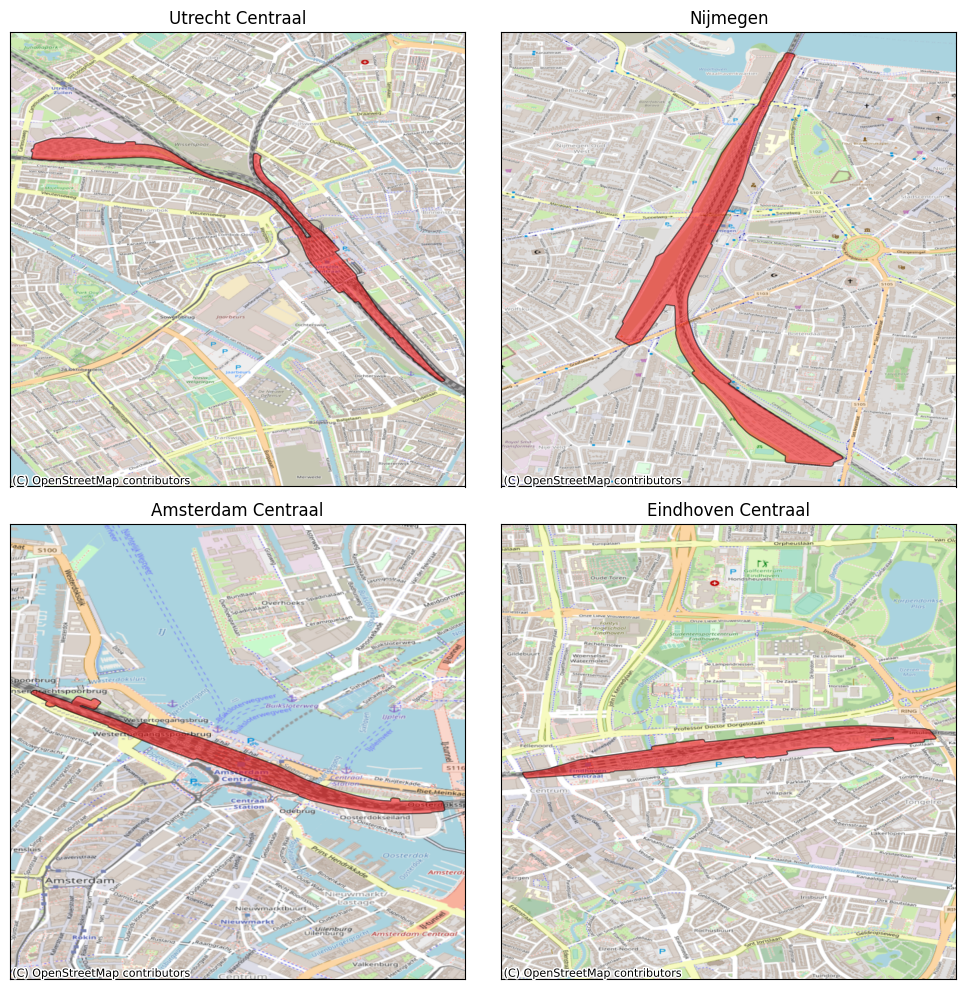

In [ ]:
# Plot four NCBGs.
REGIONS = ["Utrecht Centraal Station", "Nijmegen", "Amsterdam CS", "Eindhoven"]
TITLES = ["Utrecht Centraal", "Nijmegen", "Amsterdam Centraal", "Eindhoven Centraal"]
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for r, title, ax in zip(REGIONS, TITLES, axs.flat):
    # Plot region polygon.
    region = df_ncbg.where(df_ncbg.EMPLACEMEN == r)
    region.plot(ax=ax, color="red", edgecolor="black", alpha=0.5, linewidth=1)

    # Set title and remove labels.
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

    # Determine bounds for square images.
    x1, y1, x2, y2 = region.total_bounds
    dx = x2 - x1
    dy = y2 - y1
    r = dx / dy

    if r > 1:
        y1 = y1 - (dy * (r - 1) / 2)
        y2 = y2 + (dy * (r - 1) / 2)
    else:
        x1 = x1 - (dx * (1 / r - 1) / 2)
        x2 = x2 + (dx * (1 / r - 1) / 2)

    # Zoom out slightly.
    dx = x2 - x1
    dy = y2 - y1
    zoom = 0.1

    x1 = x1 - zoom * dx / 2
    x2 = x2 + zoom * dx / 2
    y1 = y1 - zoom * dy / 2
    y2 = y2 + zoom * dy / 2

    ax.set_xlim(x1, x2)
    ax.set_ylim(y1, y2)

    cx.add_basemap(
        ax, crs=region.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik
    )


fig.tight_layout()